In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Select one image from each class (10 images total)

In [3]:
selected_images = []
selected_labels = []

In [5]:
for class_id in range(10):
    # Find the first occurrence of each class in training set
    idx = np.where(y_train == class_id)[0][0]
    selected_images.append(x_train[idx])
    selected_labels.append(y_train[idx][0])

selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

### Define the two 3x3 diagonal filters

In [6]:
filter1 = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]], dtype=np.float32)

filter2 = np.array([[0, 0, 1],
                    [0, 1, 0],
                    [1, 0, 0]], dtype=np.float32)

### Convert filters to TensorFlow format (3, 3, 1, 1) for depthwise convolution

In [7]:
filter1_tf = tf.constant(filter1.reshape(3, 3, 1, 1), dtype=tf.float32)
filter2_tf = tf.constant(filter2.reshape(3, 3, 1, 1), dtype=tf.float32)

### Function to apply filter to an image

In [8]:
def apply_filter(image, filter_tf):
    # Convert image to float32 and normalize
    image_float = tf.cast(image, tf.float32) / 255.0

    # Apply filter to each channel separately
    filtered_channels = []
    for channel in range(3):
        channel_data = image_float[:, :, channel:channel+1]
        channel_filtered = tf.nn.depthwise_conv2d(
            channel_data[np.newaxis, :, :, :],  # Add batch dimension
            filter_tf,
            strides=[1, 1, 1, 1],
            padding='SAME'
        )
        filtered_channels.append(channel_filtered[0, :, :, 0])

    # Stack channels back together
    filtered_image = tf.stack(filtered_channels, axis=-1)
    return tf.clip_by_value(filtered_image, 0, 1).numpy()

### Apply filters to all selected images

In [11]:
filtered1_images = []
filtered2_images = []

In [12]:
for img in selected_images:
    filtered1 = apply_filter(img, filter1_tf)
    filtered2 = apply_filter(img, filter2_tf)
    filtered1_images.append(filtered1)
    filtered2_images.append(filtered2)

### CIFAR-10 class names

In [14]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

### Plot the results

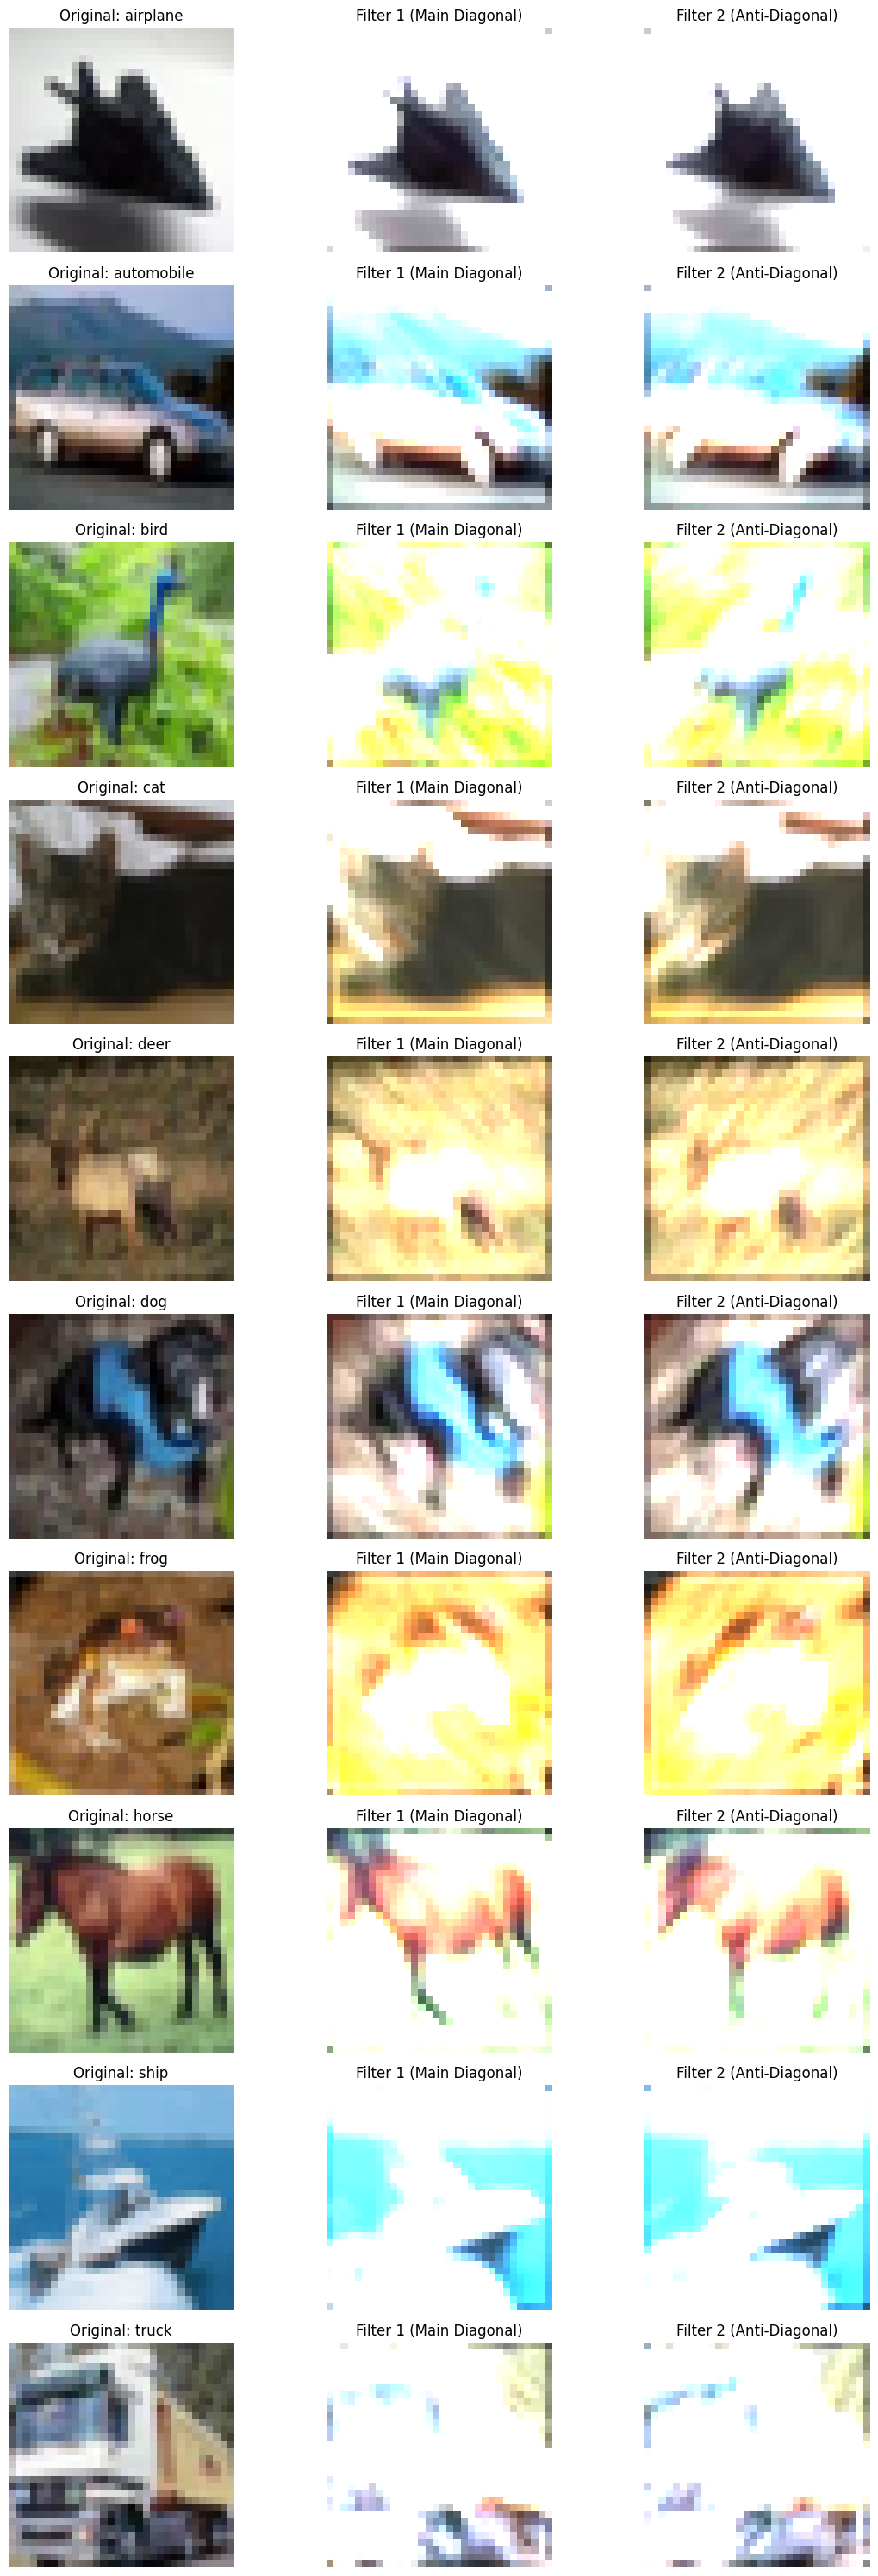

Filter 1 (Main Diagonal):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Filter 2 (Anti-Diagonal):
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [15]:
fig, axes = plt.subplots(10, 3, figsize=(12, 30))

for i in range(10):
    # Original image
    axes[i, 0].imshow(selected_images[i])
    axes[i, 0].set_title(f'Original: {class_names[selected_labels[i]]}')
    axes[i, 0].axis('off')

    # Filter 1 result (main diagonal)
    axes[i, 1].imshow(filtered1_images[i])
    axes[i, 1].set_title('Filter 1 (Main Diagonal)')
    axes[i, 1].axis('off')

    # Filter 2 result (anti-diagonal)
    axes[i, 2].imshow(filtered2_images[i])
    axes[i, 2].set_title('Filter 2 (Anti-Diagonal)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Display the filters
print("Filter 1 (Main Diagonal):")
print(filter1)
print("\nFilter 2 (Anti-Diagonal):")
print(filter2)